In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystablemotifs as sm
from pyboolnet.file_exchange import bnet2primes
import pystablemotifs.export as ex
import networkx as nx

In [2]:
model_path = '/home/spankaew/Git/astrologics/models/test_bonesis/'
model_files = os.listdir(model_path)

# Setup the simulation size
max_simulate_size = 30

# Create a dictionary object to store models
models_net = {}

# Loop through the models
for i in tqdm(model_files): 
    # Adjust model name
    model_name = i.replace('.bnet','')
    primes = bnet2primes(model_path + i)
    ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)
    models_net[model_name]=ex.networkx_succession_diagram(ar,include_attractors_in_diagram=True)

# Get the lits of nodes names
node_name = list(primes.keys())

  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 88/88 [00:09<00:00,  8.92it/s]


In [3]:
states_mtx = pd.DataFrame()
states_bin = pd.DataFrame()
for i in tqdm(list(models_net.keys())):
    # Extract states from GM nodes
    indexes = [data['index'] for _, data in models_net[i].nodes(data=True) if 'index' in data]
    labels = [data['label'] for _, data in models_net[i].nodes(data=True) if 'label' in data]
    states = [data['states'] for _, data in models_net[i].nodes(data=True) if 'states' in data]

    # Create a new label index
    new_index = []
    for idx, index in enumerate(indexes):
        if isinstance(index, int):
            new_index.append(labels[idx])
        elif isinstance(index, str):
            new_index.append(index)
    new_index

    # Convert to DataFrame
    states_df = pd.DataFrame(states)
    # Convert values to int or logical value
    states_df = states_df.map(lambda x: int(x) if pd.notnull(x) else '*')

    # Set index to the matrix 
    states_df = states_df[node_name]
    states_df_strings = states_df.apply(lambda row: ''.join(row.astype(str)), axis=1)
    new_index = [new_index[j]+'_'+states_df_strings[j] for j in range(len(states_df_strings))]

    states_df.index = new_index

    # Fill NA with *
    states_df.fillna('*',inplace=True)

    # Concatenate the matrix
    states_mtx = pd.concat([states_mtx, states_df], axis=0, ignore_index = False)
    states_mtx = states_mtx[~states_mtx.index.duplicated(keep='first')]

    # Count the index from each of the models
    states_bin = pd.concat([states_bin, states_df.index.value_counts()], axis=1, ignore_index = False)
    states_bin.fillna(0, inplace=True)

states_bin.columns = list(models_net.keys())

100%|██████████| 88/88 [00:00<00:00, 235.04it/s]


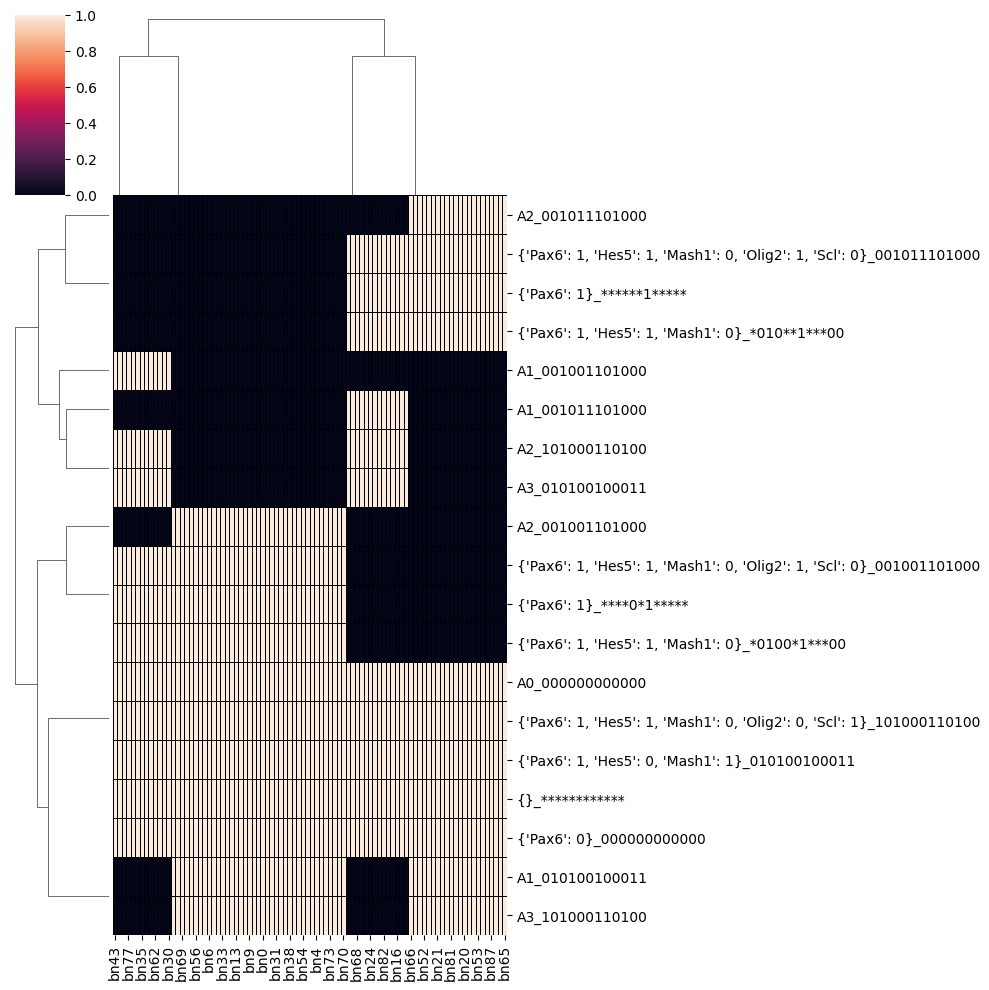

In [4]:
import seaborn as sns
sns.clustermap(states_bin, linewidth = .5, linecolor ='black')

In [18]:
models_net['bn65']

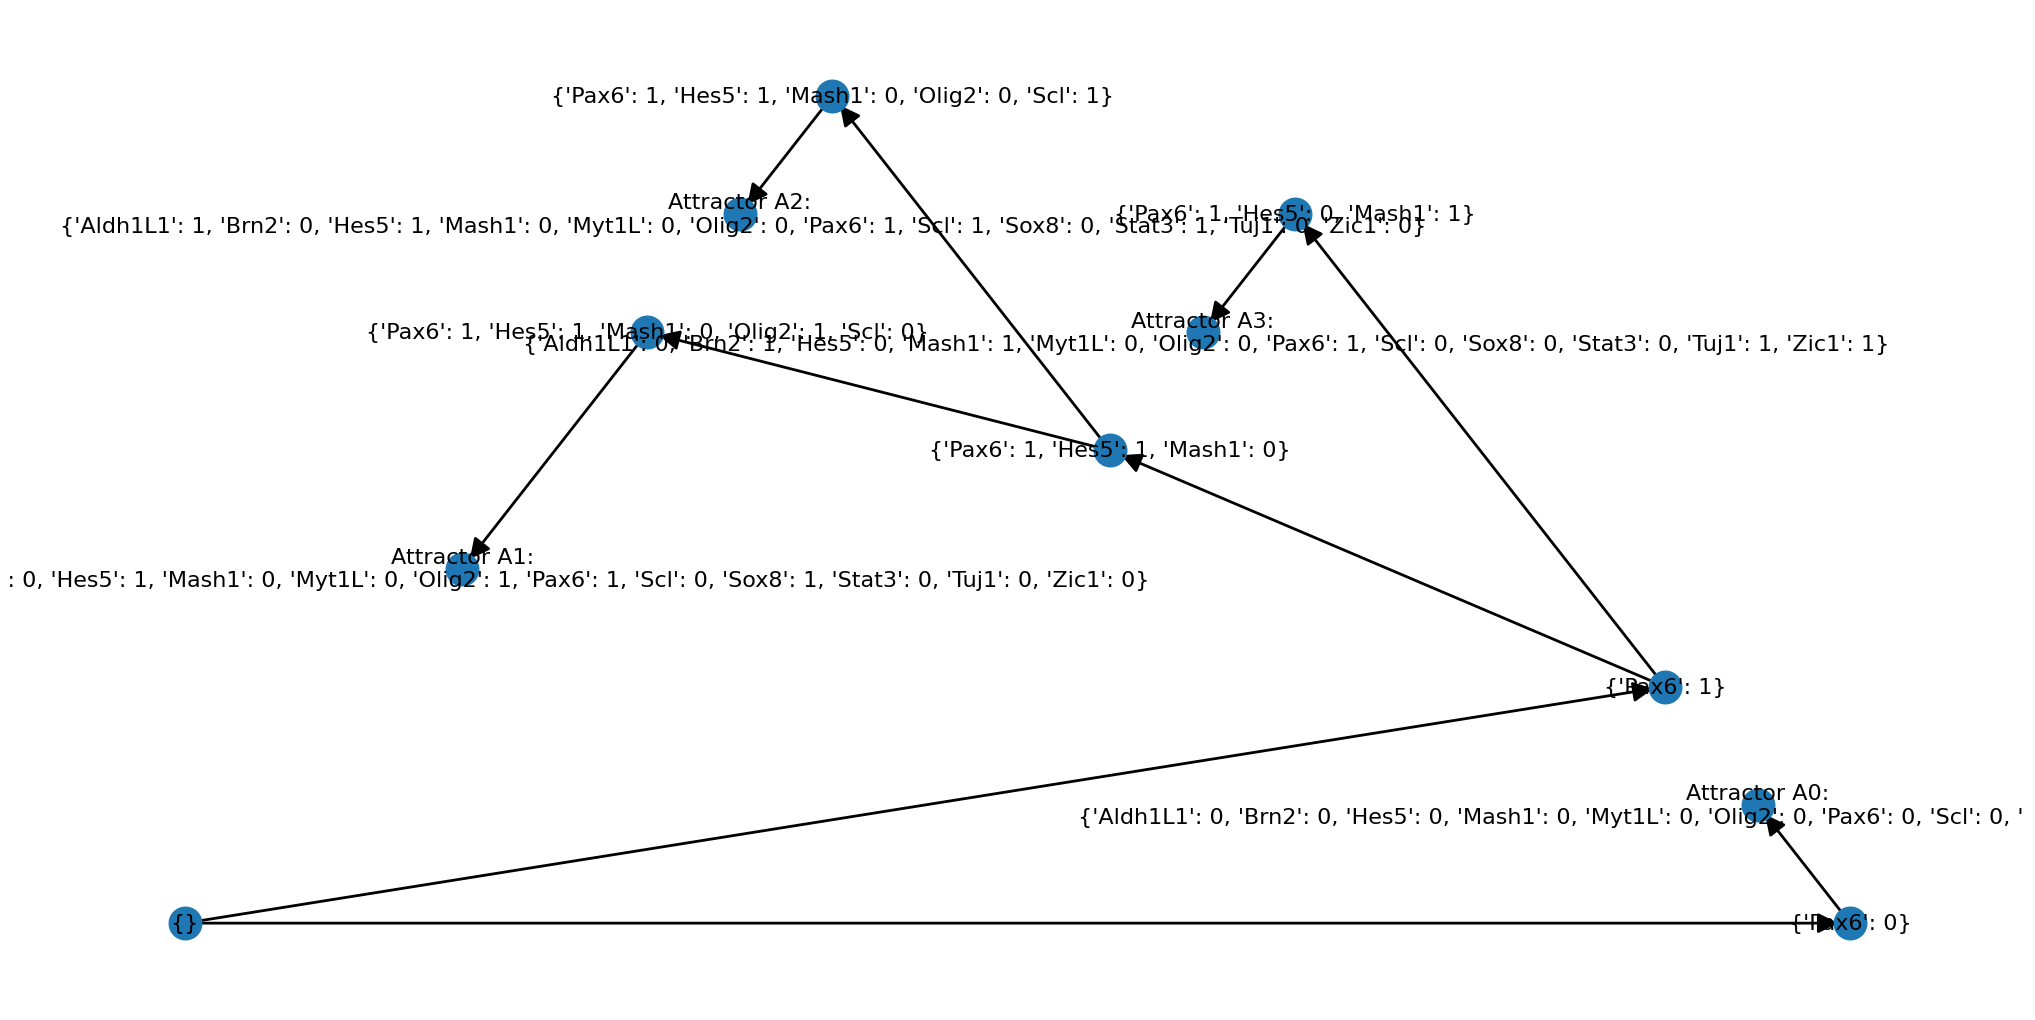

In [20]:
ex.plot_nx_succession_diagram(models_net['bn43'])

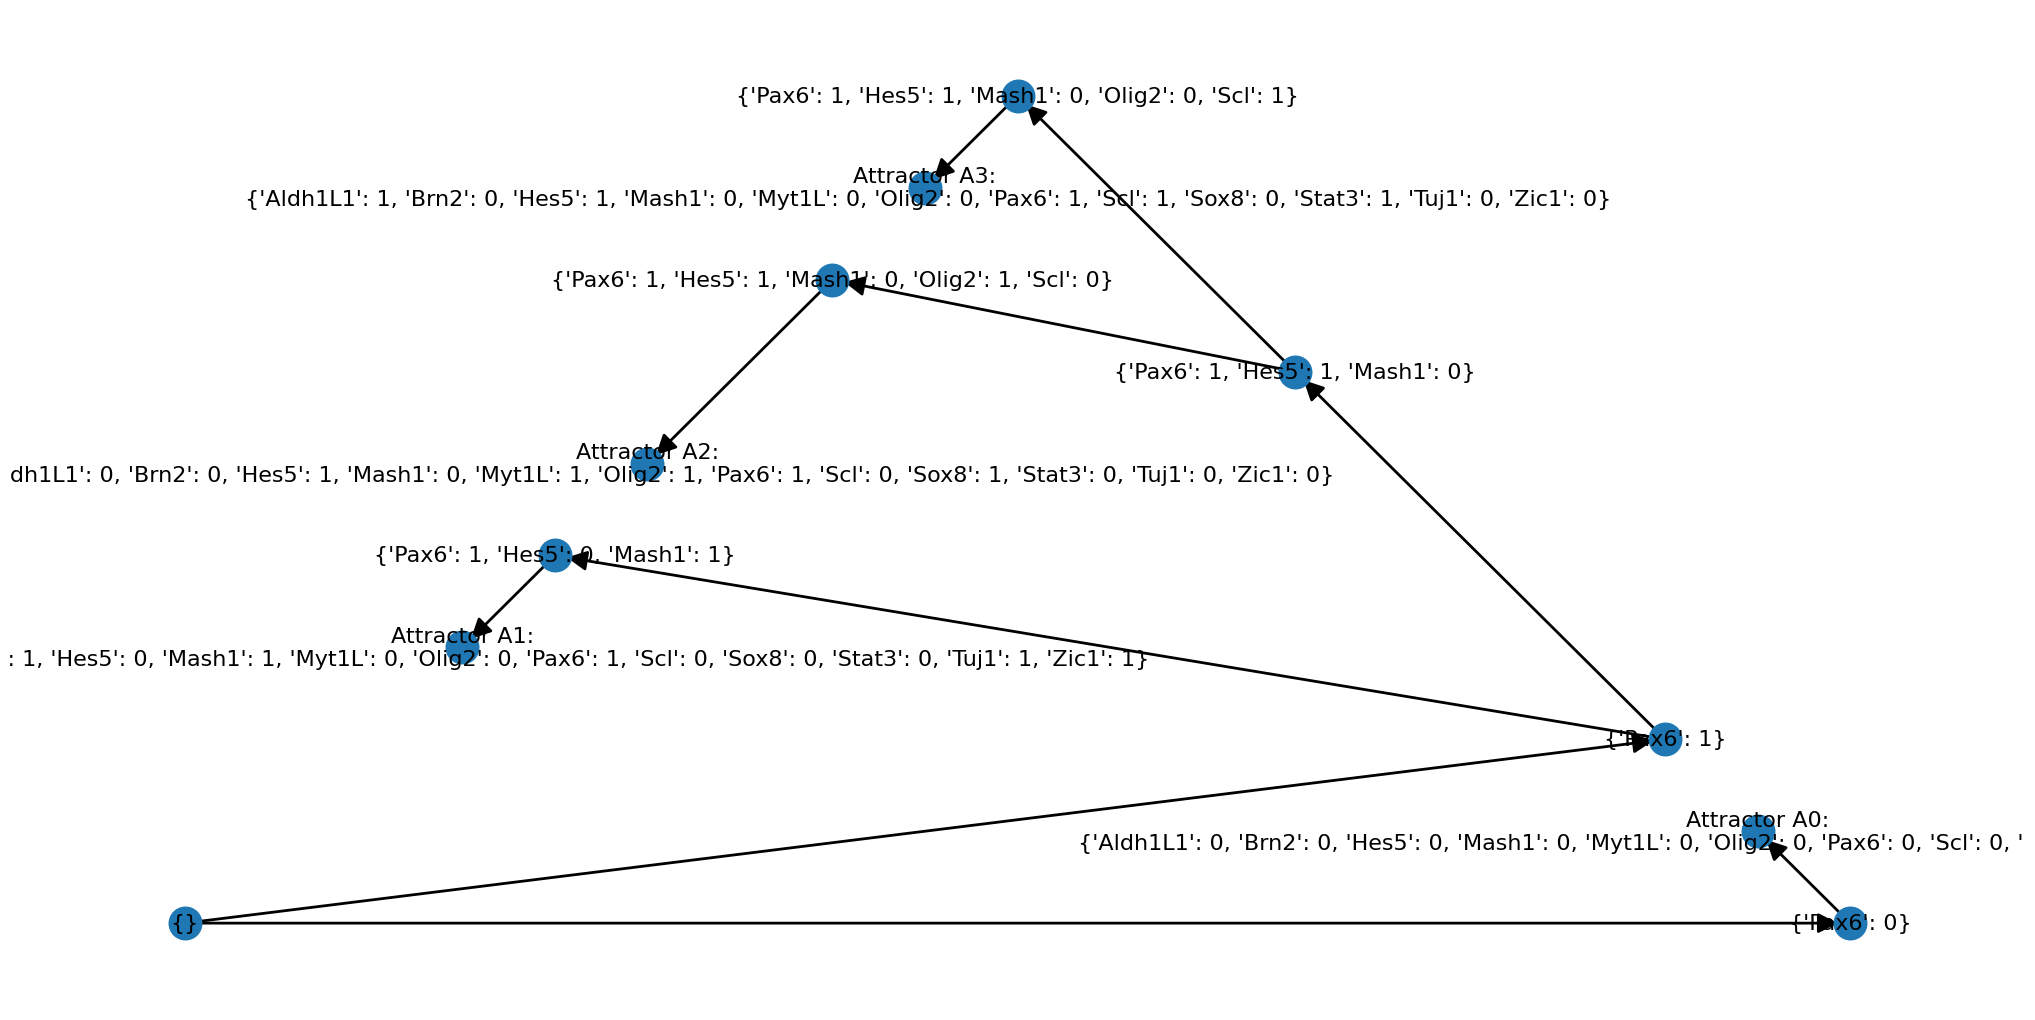

In [21]:
ex.plot_nx_succession_diagram(models_net['bn65'])

In [15]:
import numpy as np
from netrd.distance import DeltaCon

N = len(models_net)
model_list = list(models_net.keys())

# Compute pairwise DeltaCon distances
distance_matrix = np.zeros((N, N))
deltacon = DeltaCon()

# Compute the distance matrix
for i in tqdm(range(N)):
    for j in range(i+1, N):
        dist = deltacon.dist(models_net[model_list[i]], models_net[model_list[j]])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Convert to DataFrame
distance_matrix = pd.DataFrame(distance_matrix, index = model_list, columns = model_list)

  0%|          | 0/88 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
100%|██████████| 88/88 [00:06<00:00, 13.03it/s]


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


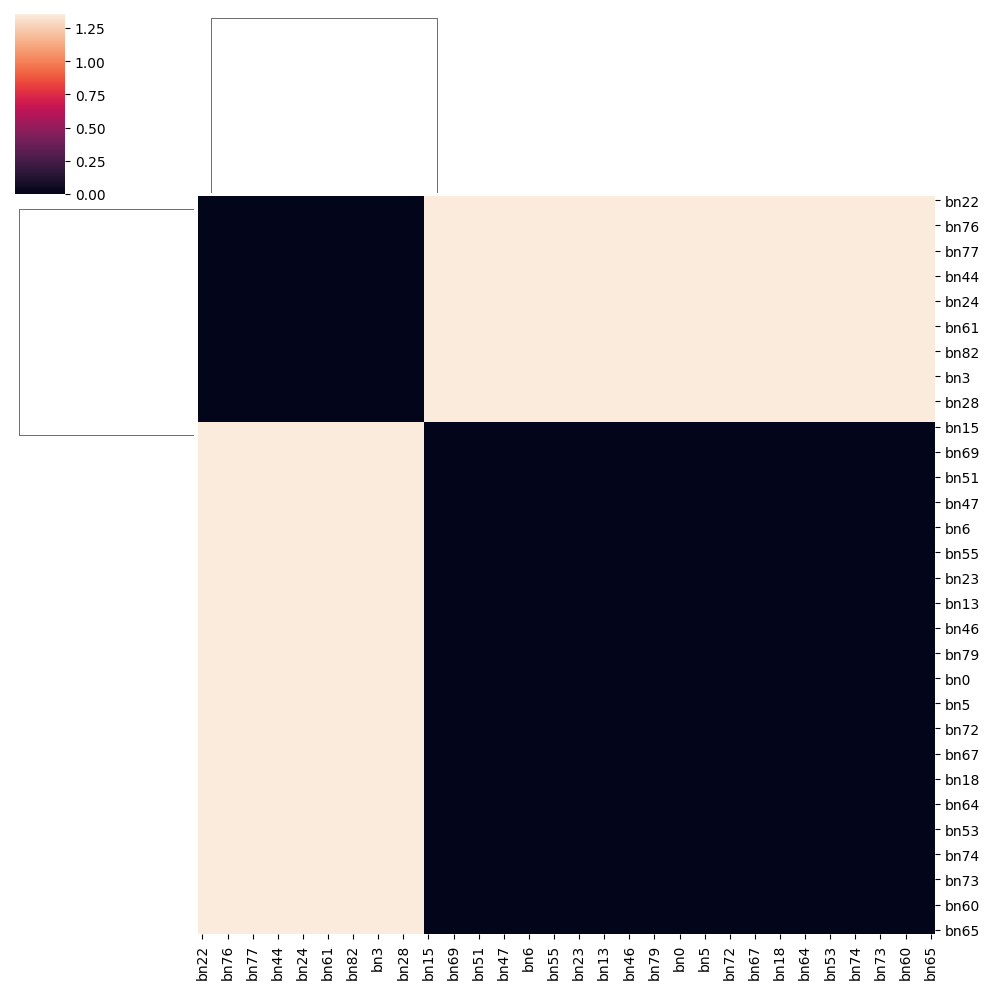

In [16]:
sns.clustermap(distance_matrix)

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Hierarchical clustering (Ward’s method)
Z = linkage(distance_matrix, method='ward')

# Cut into 2 clusters (can also use elbow or silhouette analysis)
labels = fcluster(Z, 2, criterion='maxclust')

/tmp/ipykernel_295566/2710680753.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


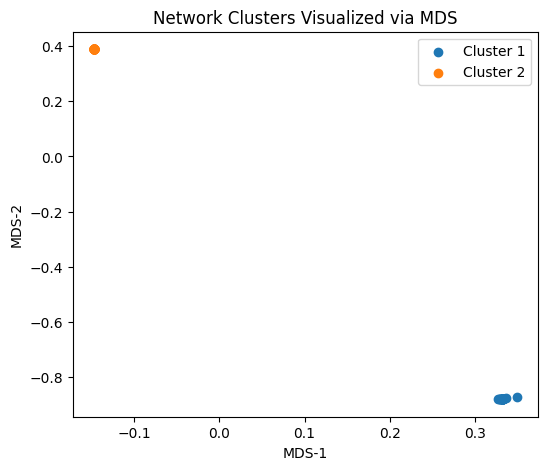

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Reduce to 2D for visualization
mds = MDS(dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)
    plt.scatter(coords[idx, 0], coords[idx, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('Network Clusters Visualized via MDS')
plt.xlabel('MDS-1')
plt.ylabel('MDS-2')
plt.show()

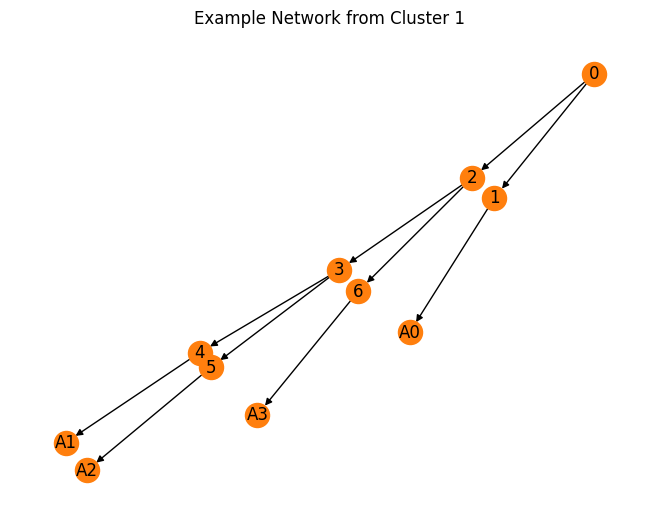

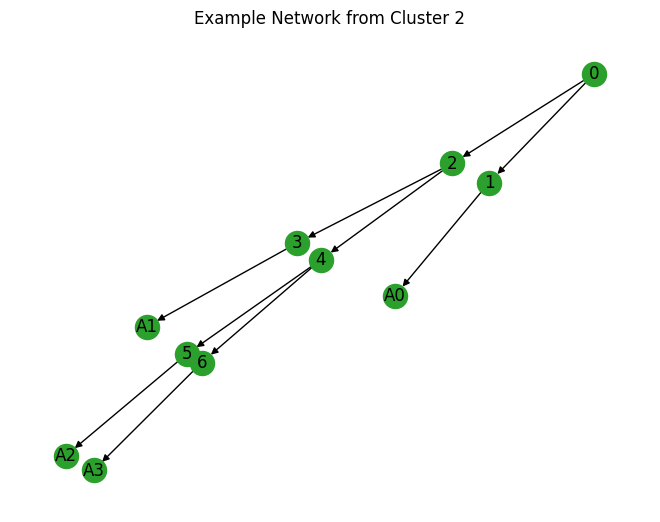

In [35]:
import networkx as nx


# Plot one network from each cluster
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)[0][0]  # get first network in this cluster
    G = models_net[model_list[idx]]
    plt.figure()
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=f"C{cluster}")
    plt.title(f'Example Network from Cluster {cluster}')
    plt.show()

In [36]:
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
model_files = os.listdir(model_path)

# Setup the simulation size
max_simulate_size = 30

# Create a dictionary object to store models
models_net = {}

# Loop through the models
for i in tqdm(model_files): 
    # Adjust model name
    model_name = i.replace('.bnet','')
    primes = bnet2primes(model_path + i)
    ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)
    models_net[model_name]=ex.networkx_succession_diagram(ar,include_attractors_in_diagram=True)

# Get the lits of nodes names
node_name = list(primes.keys())

100%|██████████| 616/616 [05:32<00:00,  1.85it/s]


In [37]:
states_mtx = pd.DataFrame()
states_bin = pd.DataFrame()
for i in tqdm(list(models_net.keys())):
    # Extract states from GM nodes
    indexes = [data['index'] for _, data in models_net[i].nodes(data=True) if 'index' in data]
    labels = [data['label'] for _, data in models_net[i].nodes(data=True) if 'label' in data]
    states = [data['states'] for _, data in models_net[i].nodes(data=True) if 'states' in data]

    # Create a new label index
    new_index = []
    for idx, index in enumerate(indexes):
        if isinstance(index, int):
            new_index.append(labels[idx])
        elif isinstance(index, str):
            new_index.append(index)
    new_index

    # Convert to DataFrame
    states_df = pd.DataFrame(states)
    # Convert values to int or logical value
    states_df = states_df.map(lambda x: int(x) if pd.notnull(x) else '*')

    # Set index to the matrix 
    states_df = states_df[node_name]
    states_df_strings = states_df.apply(lambda row: ''.join(row.astype(str)), axis=1)
    new_index = [new_index[j]+'_'+states_df_strings[j] for j in range(len(states_df_strings))]

    states_df.index = new_index

    # Fill NA with *
    states_df.fillna('*',inplace=True)

    # Concatenate the matrix
    states_mtx = pd.concat([states_mtx, states_df], axis=0, ignore_index = False)
    states_mtx = states_mtx[~states_mtx.index.duplicated(keep='first')]

    # Count the index from each of the models
    states_bin = pd.concat([states_bin, states_df.index.value_counts()], axis=1, ignore_index = False)
    states_bin.fillna(0, inplace=True)

states_bin.columns = list(models_net.keys())

100%|██████████| 616/616 [00:03<00:00, 164.52it/s]


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


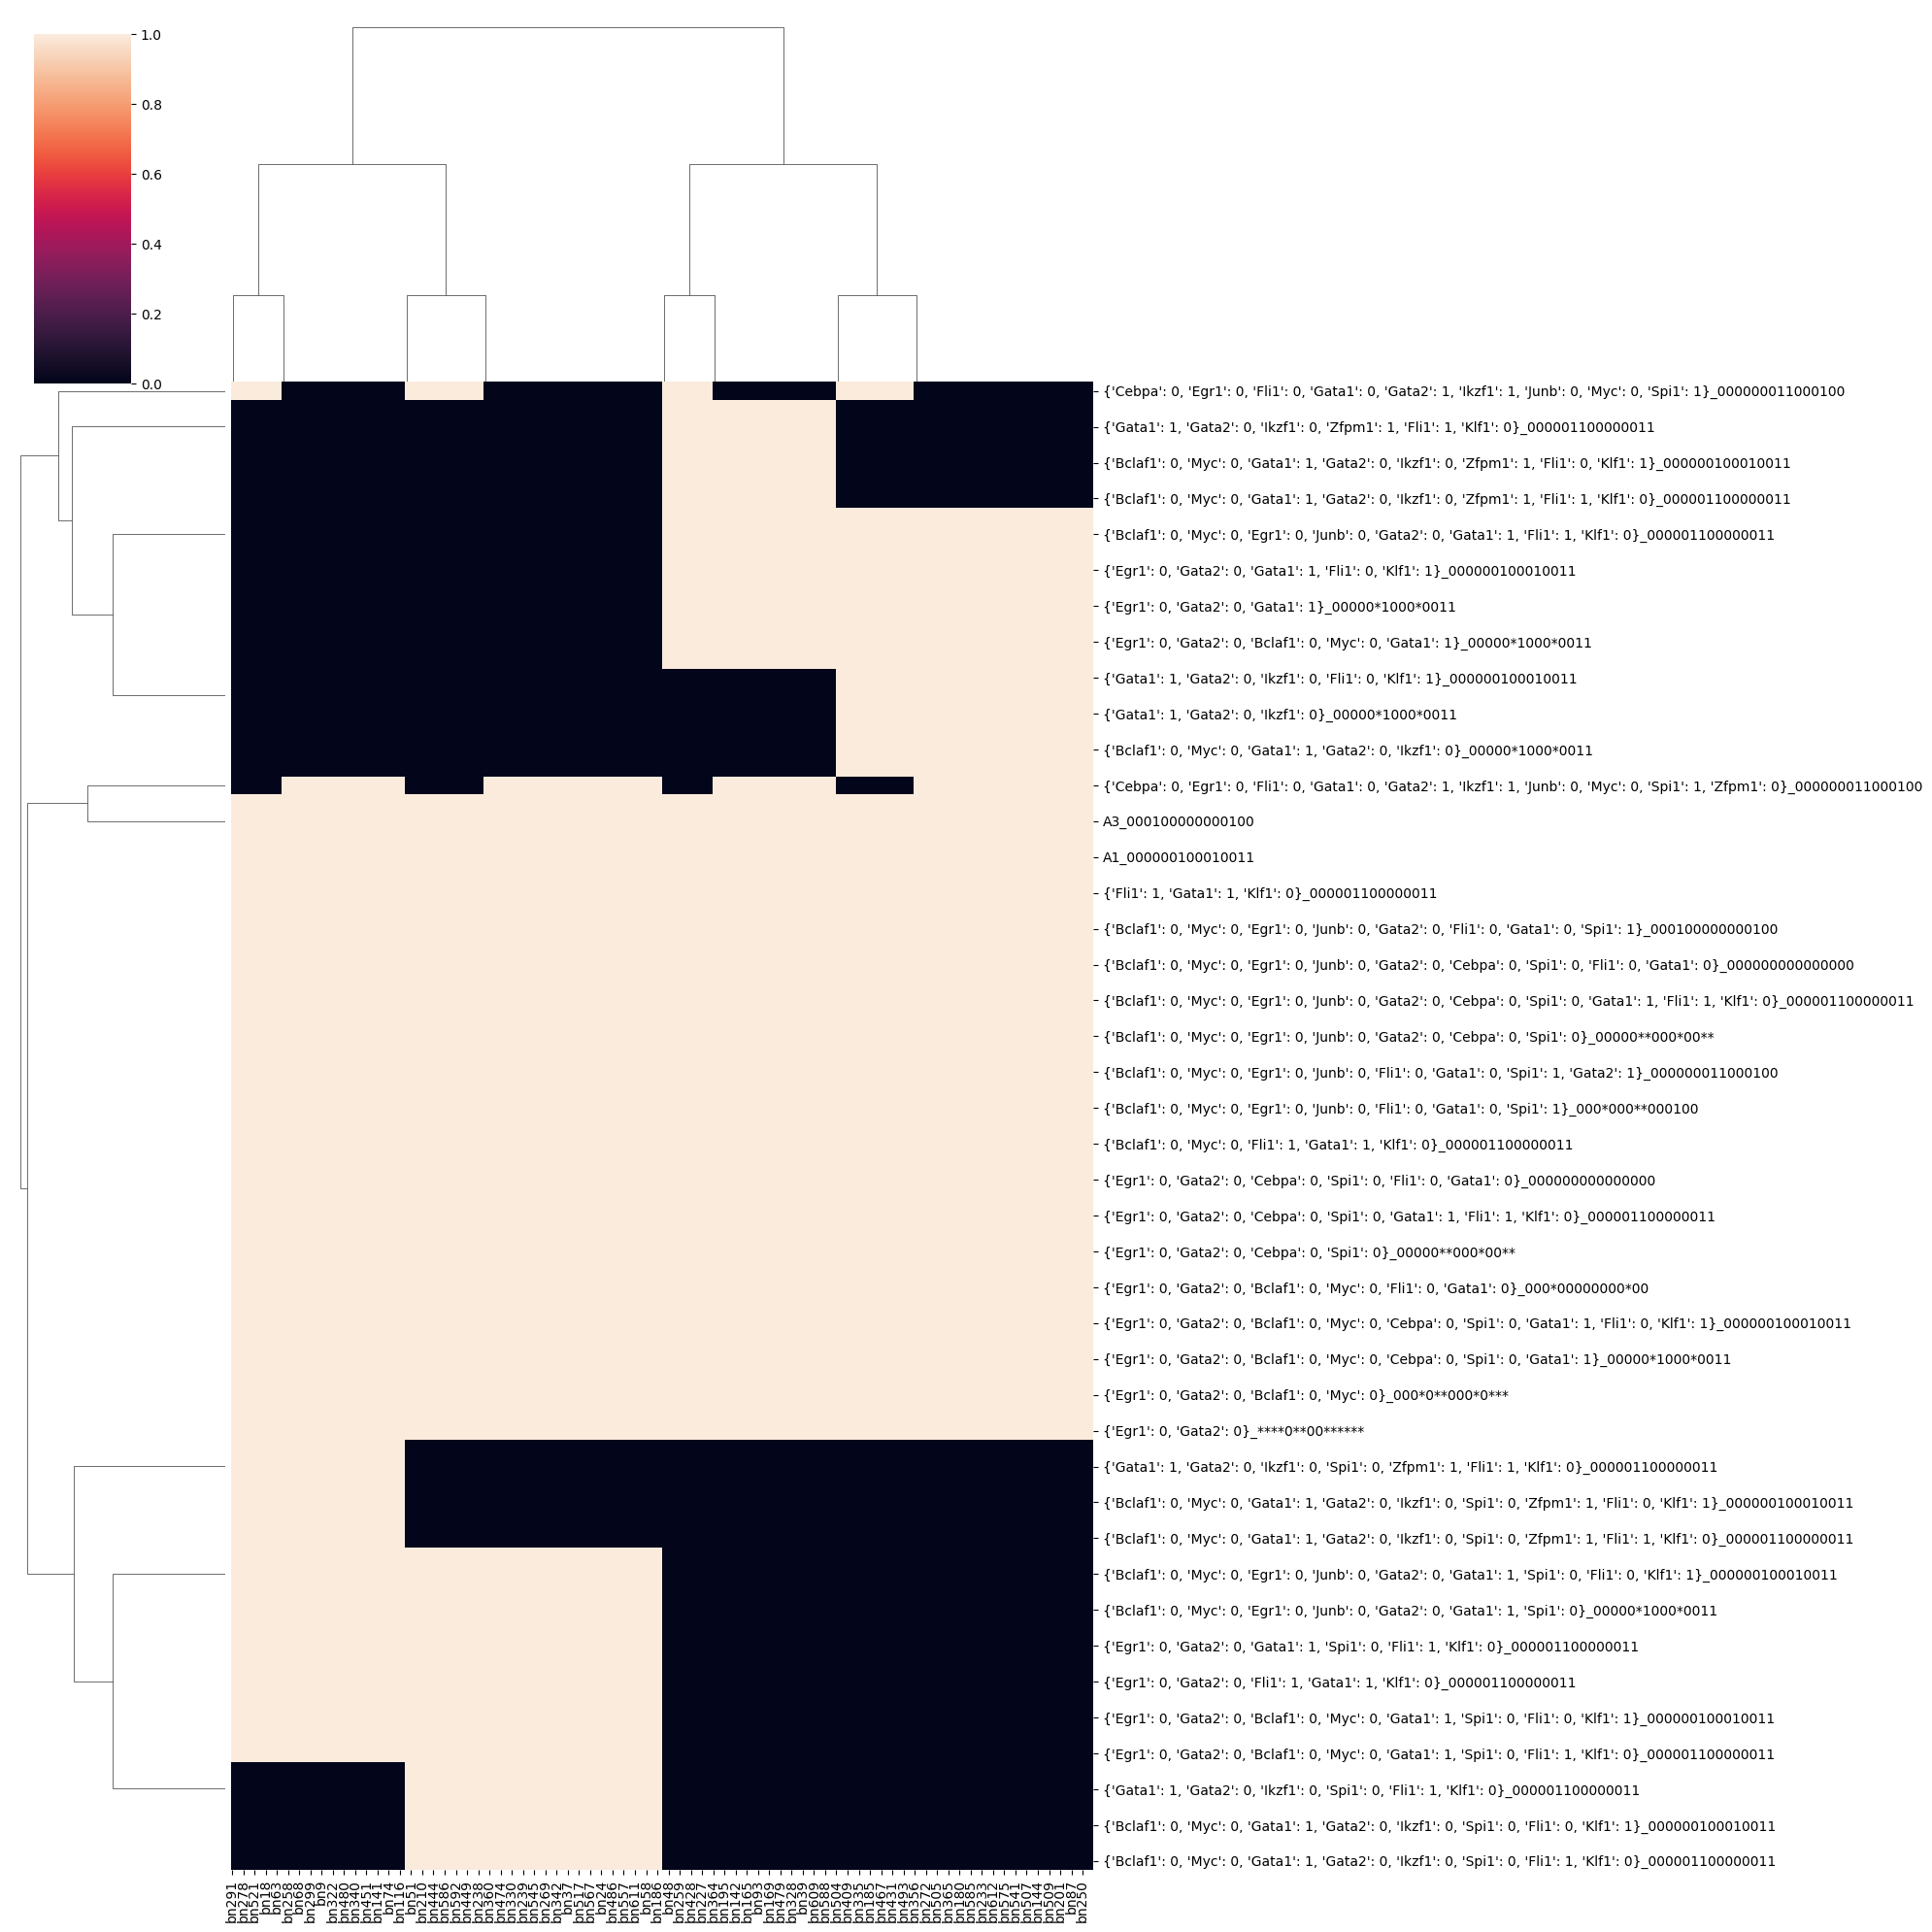

In [38]:
sns.clustermap(states_bin, figsize = (20,20))

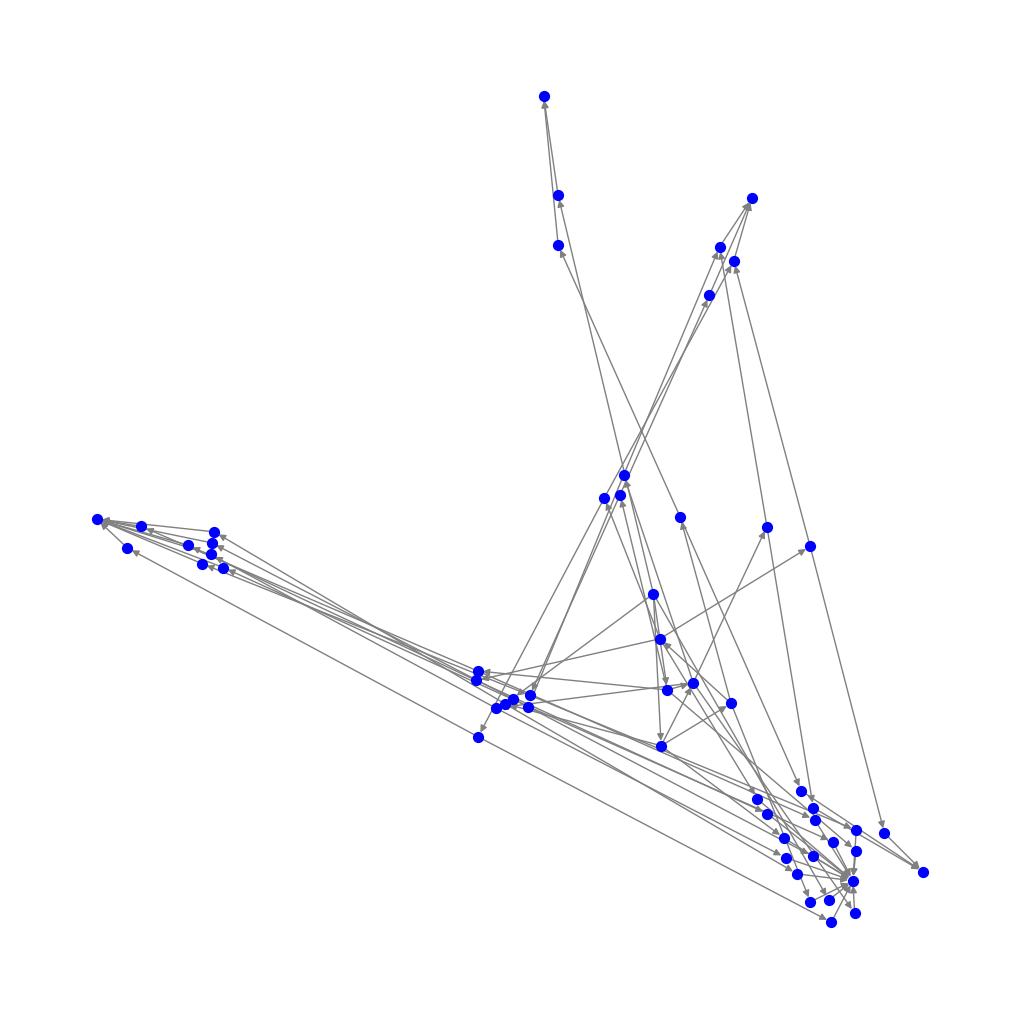

In [19]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(models_net['bn0'])  # You can change this to any other layout, e.g., circular_layout, shell_layout, etc.
nx.draw(models_net['bn0'], pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

In [41]:
import numpy as np
from netrd.distance import JaccardDistance

N = len(models_net)
model_list = list(models_net.keys())

# Compute pairwise DeltaCon distances
distance_matrix = np.zeros((N, N))
jaccard = JaccardDistance()

# Compute the distance matrix
for i in tqdm(range(N)):
    for j in range(i+1, N):
        dist = jaccard.dist(models_net[model_list[i]], models_net[model_list[j]])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Convert to DataFrame
distance_matrix = pd.DataFrame(distance_matrix, index = model_list, columns = model_list)

100%|██████████| 616/616 [03:30<00:00,  2.92it/s]


In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Hierarchical clustering (Ward’s method)
Z = linkage(distance_matrix, method='ward')

# Cut into 2 clusters (can also use elbow or silhouette analysis)
labels = fcluster(Z, 4, criterion='maxclust')

/tmp/ipykernel_295566/51926583.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


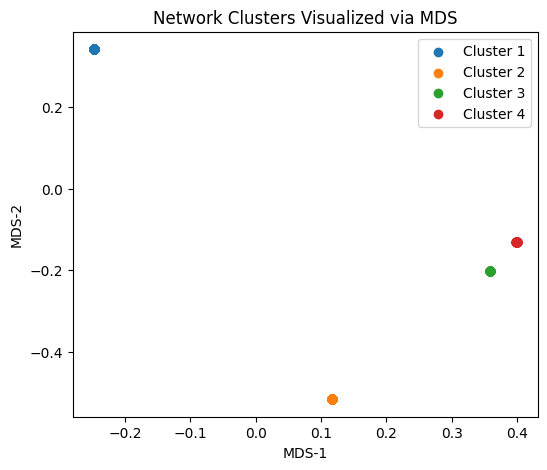

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Reduce to 2D for visualization
mds = MDS(dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)
    plt.scatter(coords[idx, 0], coords[idx, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('Network Clusters Visualized via MDS')
plt.xlabel('MDS-1')
plt.ylabel('MDS-2')
plt.show()

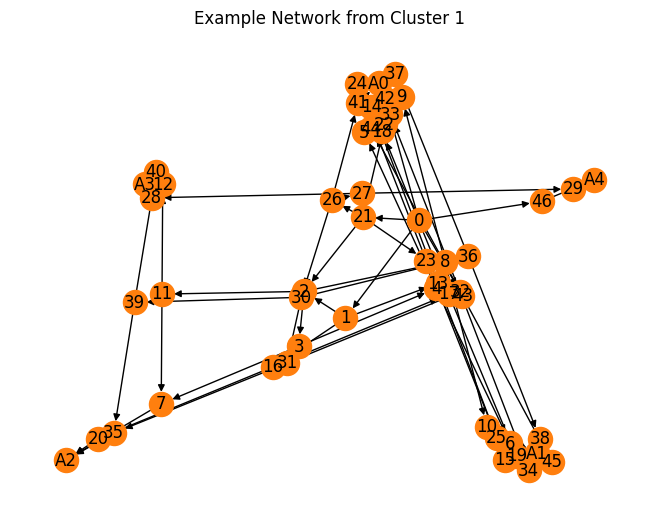

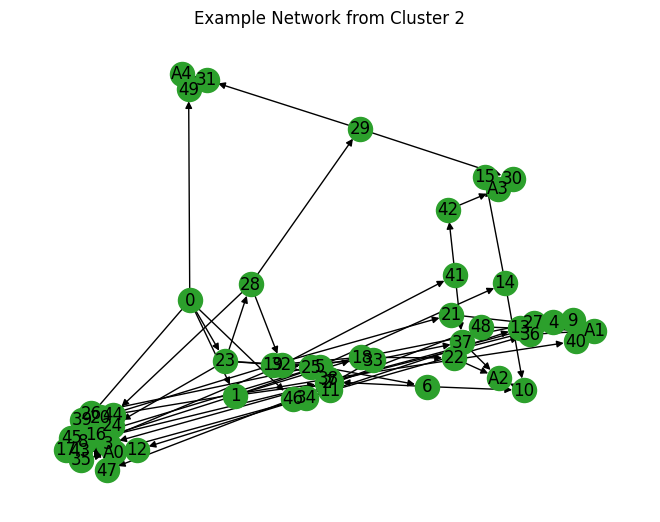

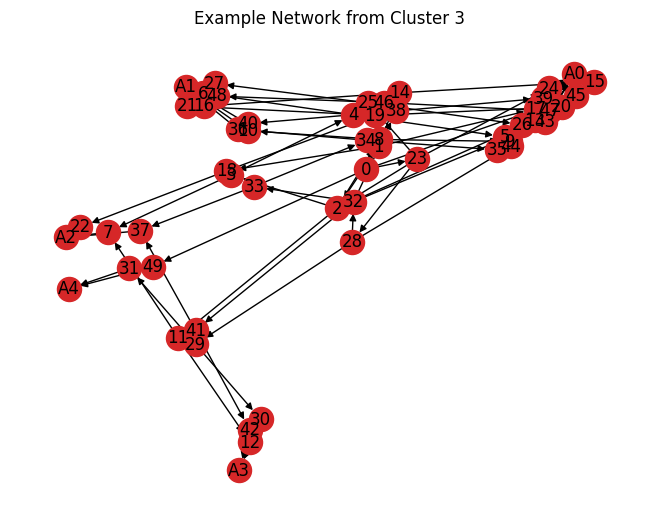

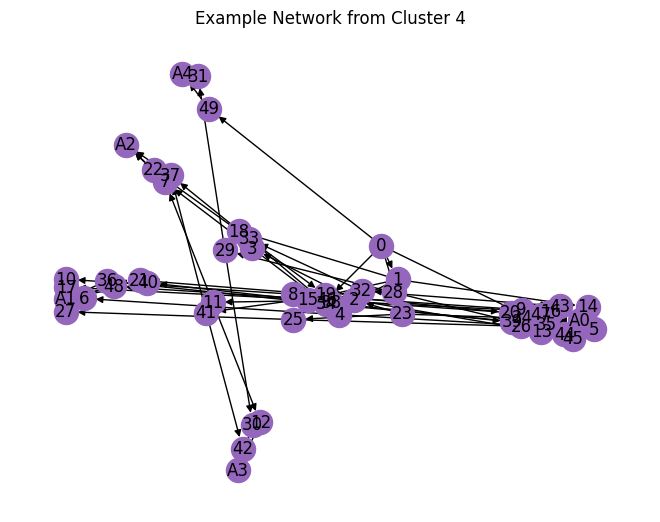

In [51]:
import networkx as nx


# Plot one network from each cluster
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)[0][0]  # get first network in this cluster
    G = models_net[model_list[idx]]
    plt.figure()
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=f"C{cluster}")
    plt.title(f'Example Network from Cluster {cluster}')
    plt.show()

In [67]:
model_path = '/home/spankaew/Git/astrologics/models/Invasion/'
model_files = os.listdir(model_path)

# Setup the simulation size
max_simulate_size = 30

# Create a dictionary object to store models
models_net = {}

# Loop through the models
for i in tqdm(model_files[0:30]): 
    # Adjust model name
    model_name = i.replace('.bnet','')
    primes = bnet2primes(model_path + i)
    ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)
    models_net[model_name]=ex.networkx_succession_diagram(ar,include_attractors_in_diagram=True)

# Get the lits of nodes names
node_name = list(primes.keys())

  0%|          | 0/30 [01:55<?, ?it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/pystablemotifs/format.py:27: SyntaxWarning: invalid escape sequence '\s'
  s = re.sub("\s*\*\s*=\s*",",\t",rules) # replace "=" with ",\t"
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/pystablemotifs/format.py:28: SyntaxWarning: invalid escape sequence '\s'
  s = re.sub("\s+not\s+"," !",s, flags=re.IGNORECASE) # not -> !
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/pystablemotifs/format.py:29: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\(\s*not\s+","(!",s, flags=re.IGNORECASE) # not -> ! (with parens)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/pystablemotifs/format.py:30: SyntaxWarning: invalid escape sequence '\s'
  s = re.sub("\s*~\s*"," !",s, flags=re.IGNORECASE) # ~ -> !
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/pystablemotifs/format.py:31: SyntaxWarnin

KeyboardInterrupt: 

['bn168.bnet',
 'bn602.bnet',
 'bn157.bnet',
 'bn45.bnet',
 'bn8.bnet',
 'bn109.bnet',
 'bn307.bnet',
 'bn12.bnet',
 'bn530.bnet',
 'bn321.bnet',
 'bn547.bnet',
 'bn487.bnet',
 'bn408.bnet',
 'bn404.bnet',
 'bn566.bnet',
 'bn494.bnet',
 'bn580.bnet',
 'bn65.bnet',
 'bn122.bnet',
 'bn421.bnet',
 'bn170.bnet',
 'bn42.bnet',
 'bn351.bnet',
 'bn553.bnet',
 'bn186.bnet',
 'bn326.bnet',
 'bn238.bnet',
 'bn131.bnet',
 'bn212.bnet',
 'bn499.bnet']